In [332]:
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [333]:
def plot_all_channels(events, data, color = None):
    figure, axes = plt.subplots(nrows = len(data.ch_names), figsize = (20, 0.5 * len(data.ch_names)))
    plt.subplots_adjust(
        left = 0.1,
        bottom = 0.1,
        right = 0.9,
        top = 0.9,
        wspace = 0,
        hspace = 0
    )
    
    x = data.times
    
    if color is None:
        color_list = list(mcolors.TABLEAU_COLORS.keys())
        # Drop color gray cuz its barely visible
        color_list = [ col for col in color_list if col != 'tab:gray' ]
    else:
        color_list = list(color)
    
    for i, channel in enumerate(data.ch_names):
        move_events = events[events['Channel'] == channel]
    
        y = data.get_data(picks = [i])[0]
    
        axes[i].plot(x, y, linewidth = 0.5, color = 'black')
        axes[i].set_ylim(-10, 10)
        axes[i].get_xaxis().set_ticks([])
        axes[i].get_yaxis().set_ticks([])
        axes[i].set_ylabel(channel, rotation = 0, labelpad = 60, loc = 'center')
        axes[i].set_xlim(0, 10)
    
        for index, row in move_events.iterrows():
            start = int(row['EventStart'])
            end = int(row['EventEnd'])
            color = color_list[index % len(color_list)]
    
            axes[i].plot(x[start:end], y[start:end], linewidth = 1, color = color)
    
        if i != 0:
            axes[i].spines['top'].set_visible(False)
    
        if i != len(data.ch_names) - 1:
            axes[i].spines['bottom'].set_visible(False)
    
    plt.show()

# Filtering the detected events: updated algorithm

In [334]:
with open('python/methods.py', 'r') as file:
    exec(file.read())

In [335]:
sample = 'W2/C3'
data = read_pickle(f'output/spontaneous-movement/{sample}/emg/filter.pkl')
events = read_pickle(f'output/spontaneous-movement/{sample}/emg/movement_events.pkl')
no_movement = read_pickle(f'output/spontaneous-movement/{sample}/emg/no_movement_events.pkl')

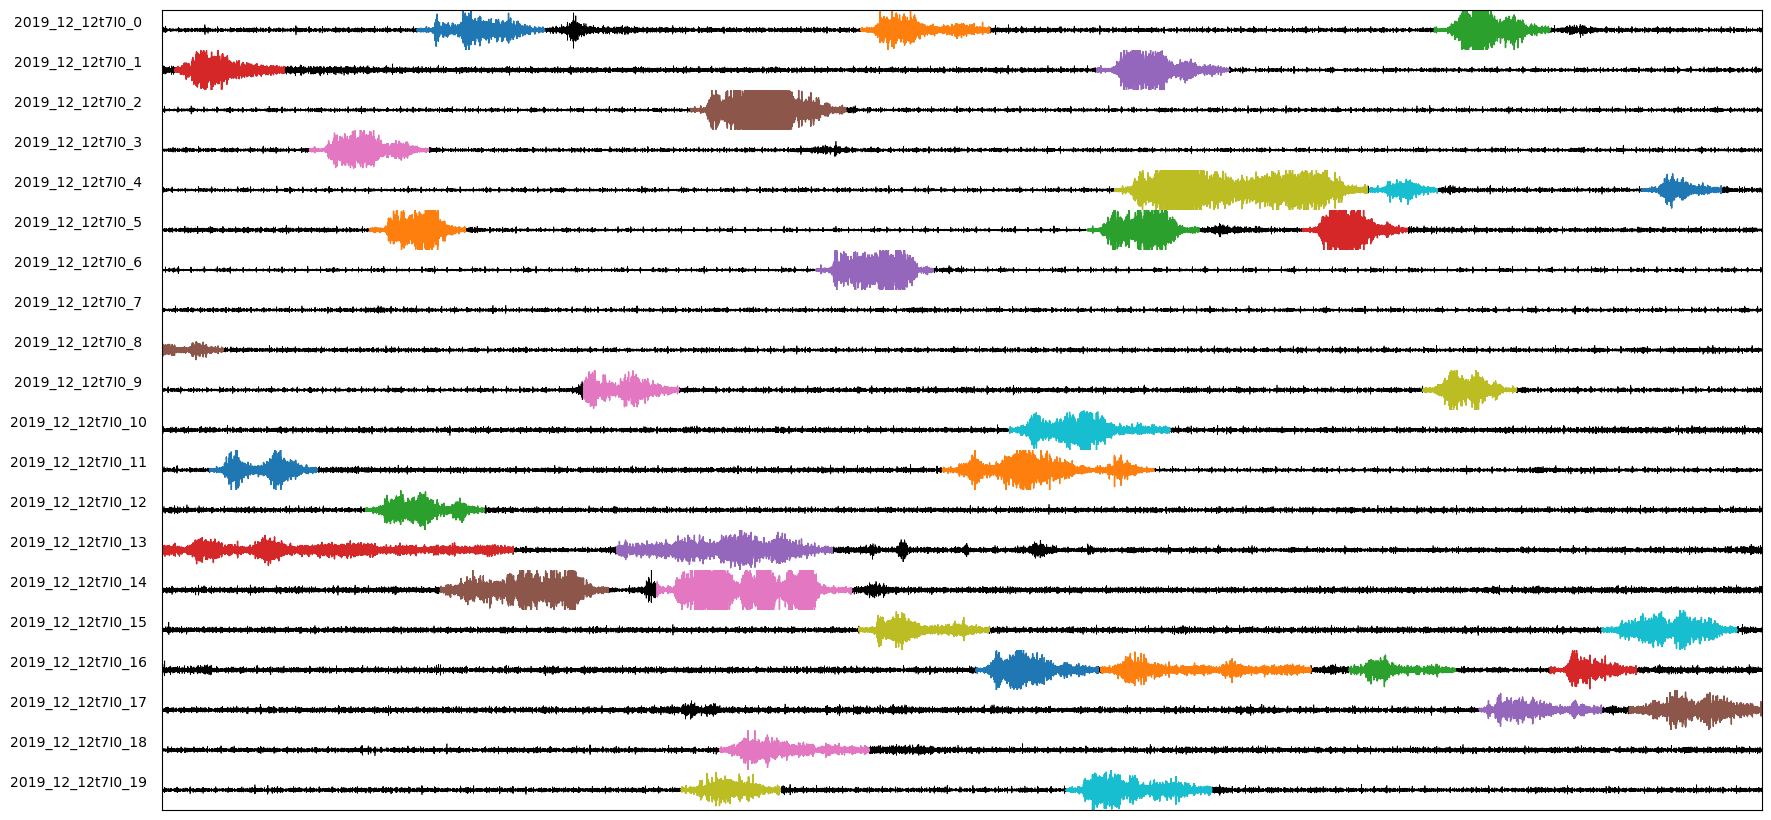

In [336]:
plot_all_channels(events, data)

## Step 1: Filter events by amplitude to remove false positives.

In [337]:
amplitude_cutoff = np.max(no_movement['Amplitude']) * 2
print(amplitude_cutoff)
drop_events = events[ events['Amplitude'] < amplitude_cutoff ]
print(f'Events to be dropped: {len(drop_events)}')

0.9410801590884125
Events to be dropped: 1


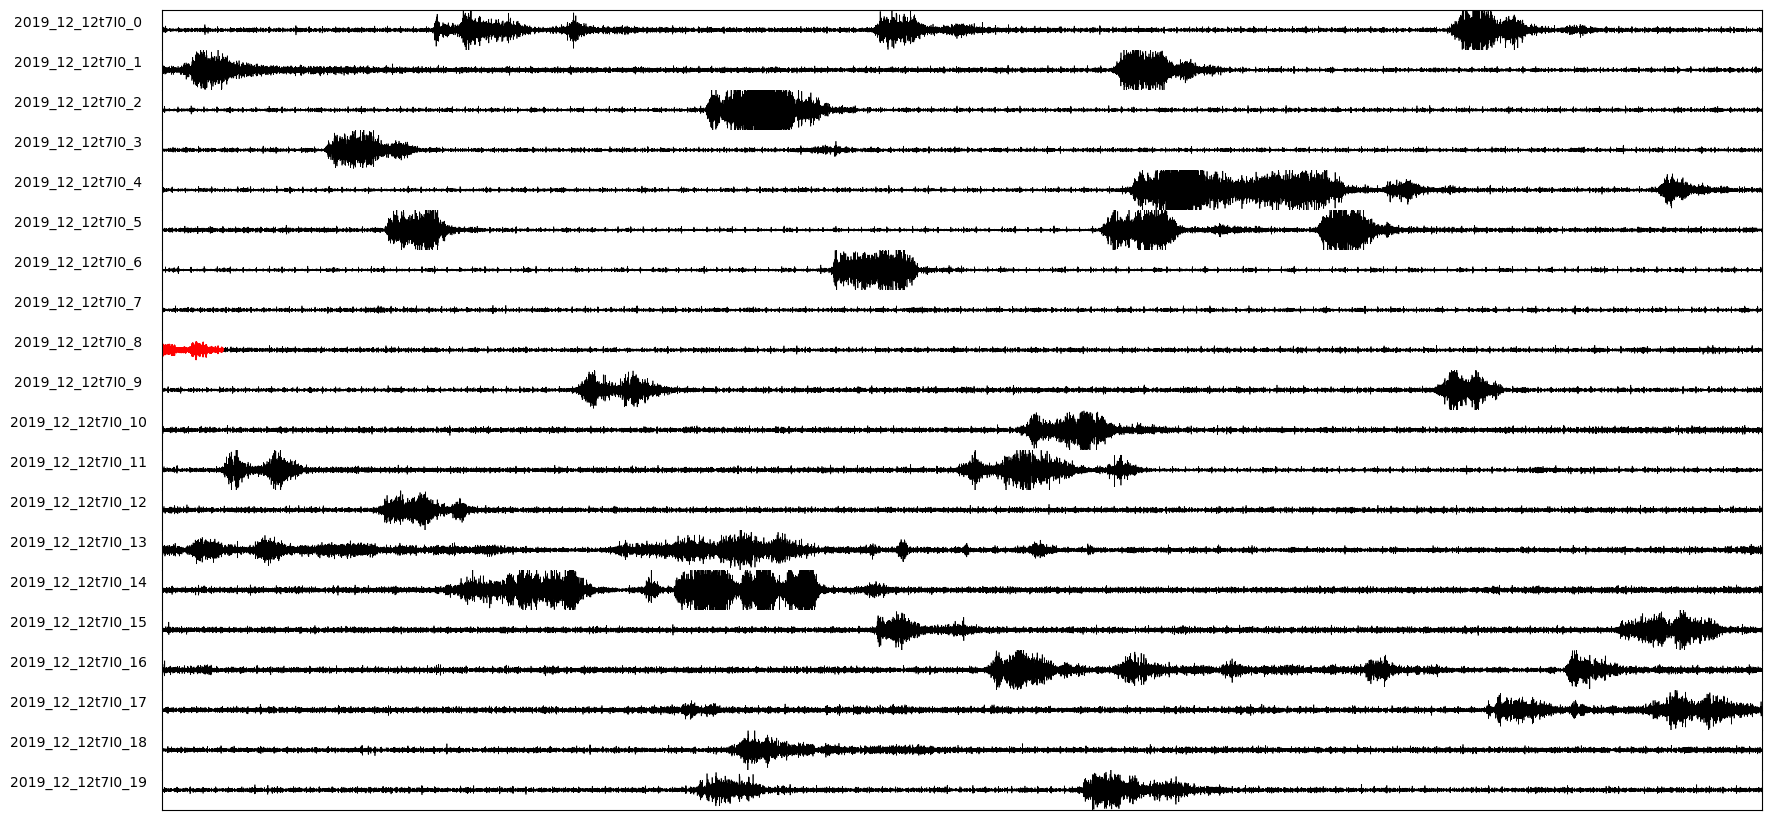

In [338]:
plot_all_channels(drop_events, data, color = ['red'])

In [339]:
print(f'Number of events before filtering: {len(events)}')
events = events[ events['Amplitude'] >= amplitude_cutoff ]
print(f'Number of events after filtering: {len(events)}')

Number of events before filtering: 36
Number of events after filtering: 35


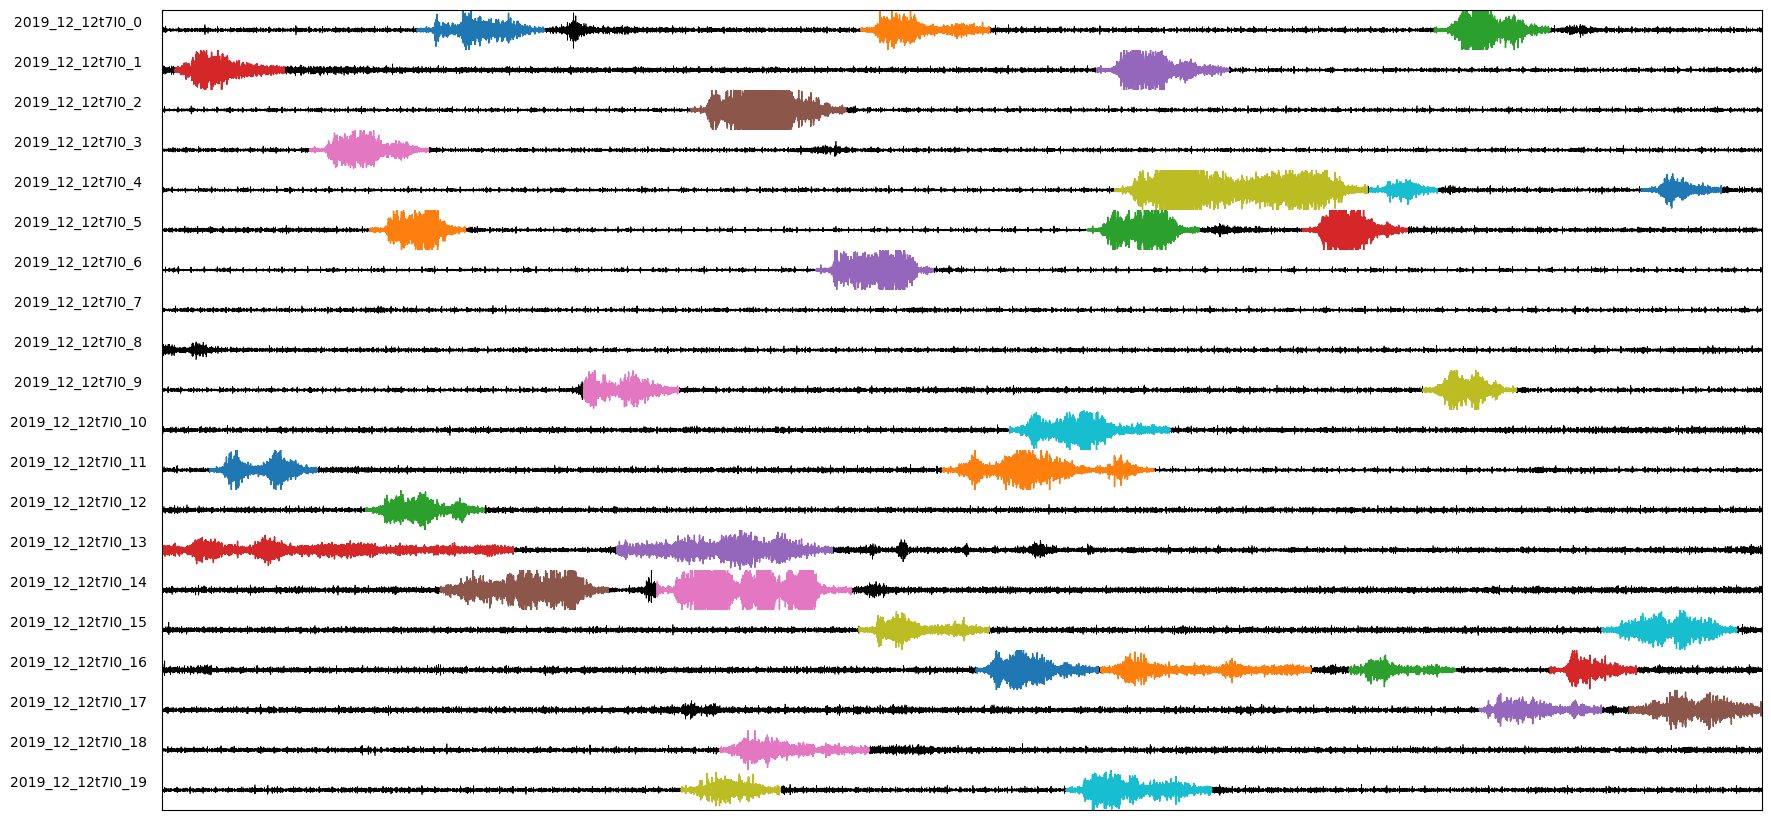

In [340]:
plot_all_channels(events, data)

## Step 2: Drop events that are at the very beginning / very end of the recording.

In [341]:
calm_time = 0.1
drop_events_start = events[ events['Start'] <= calm_time ]
drop_events_end = events[ events['End'] >= np.max(data.times) - calm_time ]
drop_events = pd.concat([drop_events_start, drop_events_end], ignore_index = True)
print(f'Events to be dropped: {len(drop_events)}')

Events to be dropped: 3


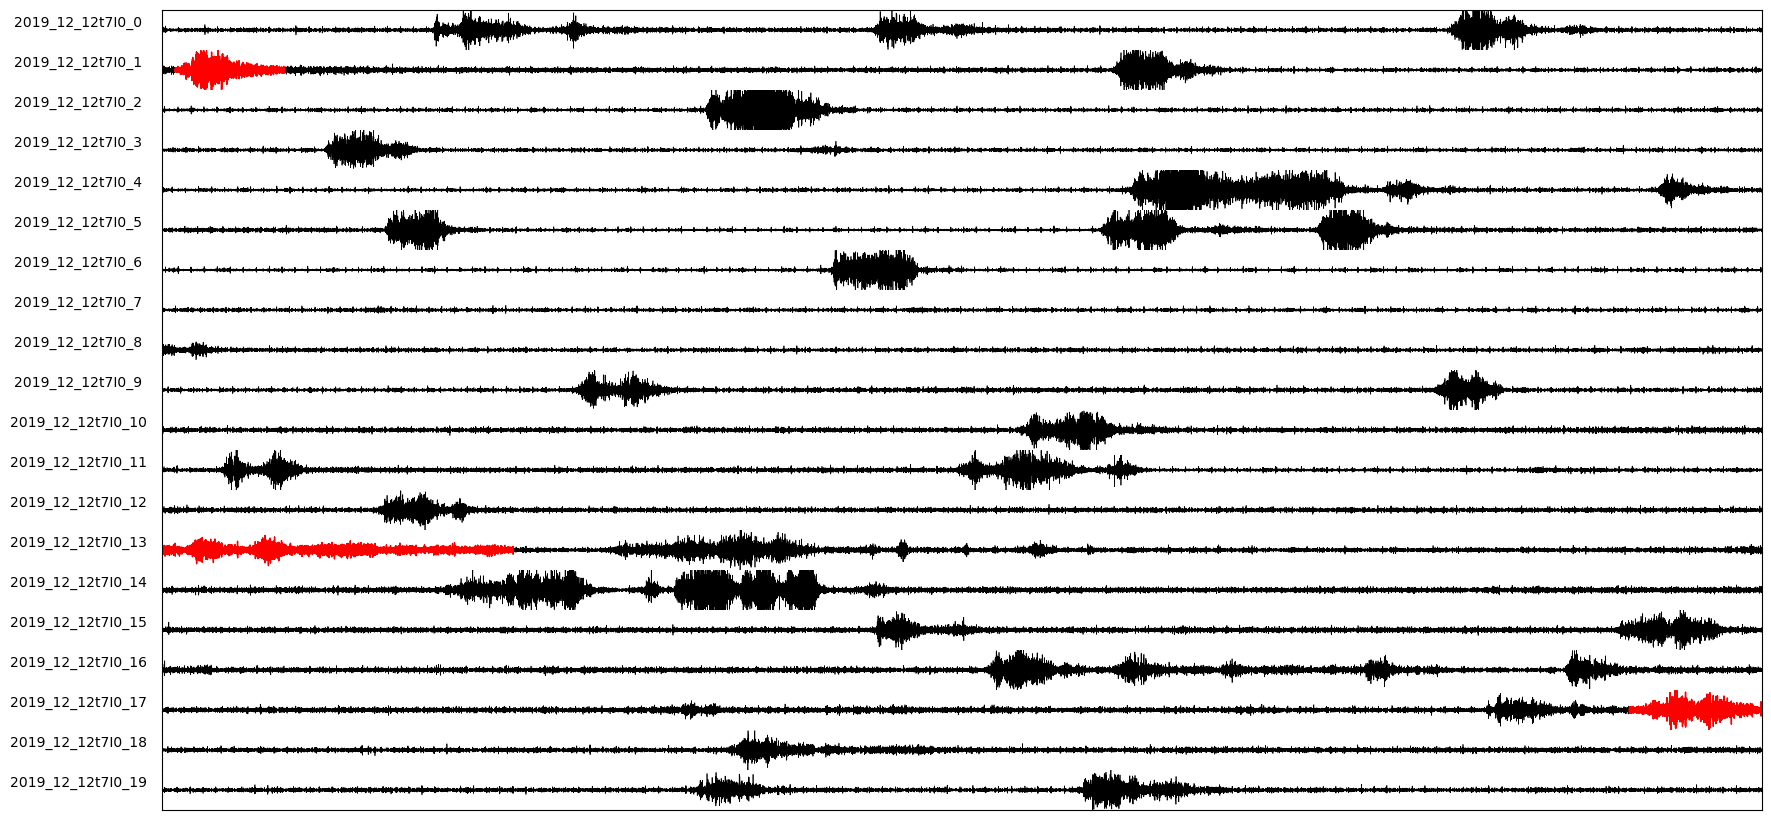

In [342]:
plot_all_channels(drop_events, data, color = ['red'])

In [343]:
print(f'Number of events before filtering: {len(events)}')
events = events[ events['Start'] > calm_time ]
events = events[ events['End'] < np.max(data.times) - calm_time ]
print(f'Number of events after filtering: {len(events)}')

Number of events before filtering: 35
Number of events after filtering: 32


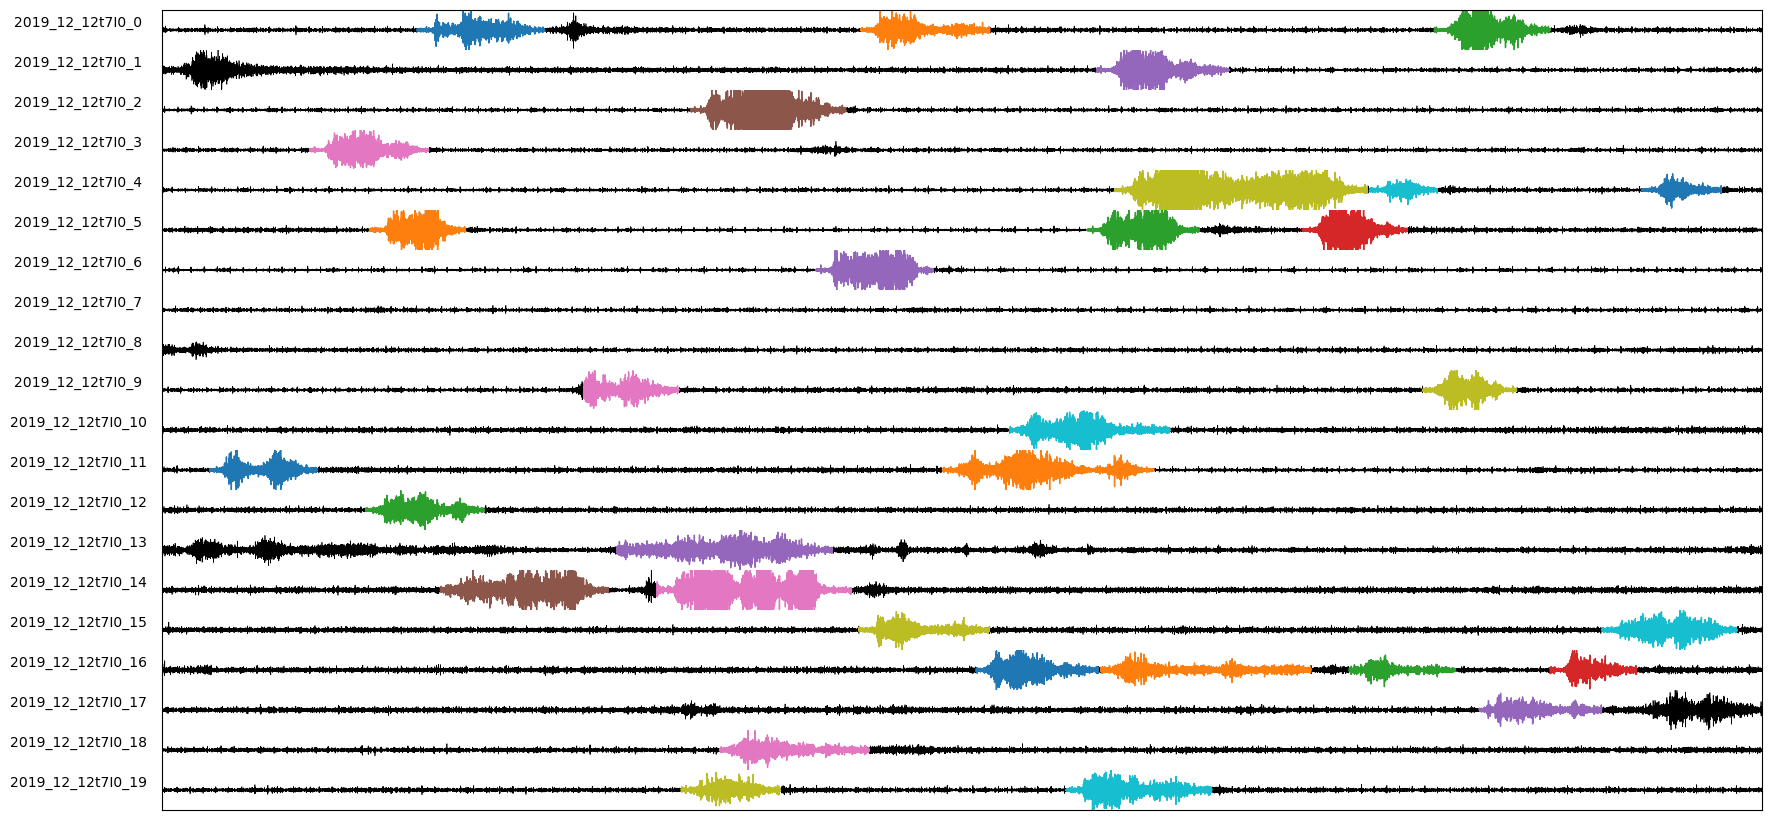

In [344]:
plot_all_channels(events, data)

## Step 3: Determine exact movement onset / offset time.

The onset time of some events is estimated correctly; others not so much. There seems to be some movement before the detected period, or it would be useful to split the event into two.

In [345]:
rest_amplitude = np.mean(no_movement['Amplitude'])
print(f'Mean resting amplitude {rest_amplitude}')

Mean resting amplitude 0.3827704486434124


In [346]:
def determine_exact_time(event, data, rest_amplitude, expand_start = 0.25, expand_end = 0.25,
                         window_size = 200, resample_factor = 4):
    import numpy as np
    import pandas as pd

    sfreq = data.info['sfreq']

    # Get event data
    # Signal start and end times are expanded by a constant to ensure capturing the full event.
    channel = event['Channel']
    event_start = np.max([event['Start'] - expand_start, 0])
    event_end = np.min([event['End'] + expand_end, np.max(data.times)])

    event_data = data.copy().pick(picks = [channel]).crop(tmin = event_start, tmax = event_end)
    y = event_data.get_data()[0]

    # Resample the data
    y = y[::resample_factor]
    new_sfreq = int(sfreq / resample_factor)

    # Smooth the signal by rolling average
    smooth_y = np.convolve(np.abs(y), np.ones(window_size) / window_size, mode = 'same')
    smooth_y = smooth_y - rest_amplitude

    # Find where the movement happens
    signal_over_threshold = smooth_y >= 0
    change_indices = np.where(np.diff(signal_over_threshold))[0]

    movement_data = pd.DataFrame({
        'EventStart': np.insert(change_indices + 1, 0, 0),
        'EventEnd': np.append(change_indices, len(signal_over_threshold))
    })

    movement_data['Movement'] = signal_over_threshold[movement_data['EventStart']]

    # Calculate the movement time in points
    movement_data['EventLength'] = list(movement_data['EventEnd'] - movement_data['EventStart'])
    movement_data = movement_data[movement_data['Movement']]

    # Recalculate the event start and end times as they are relative to the event start
    movement_data['Start'] = movement_data['EventStart'] / new_sfreq + event_start
    movement_data['Start'] = movement_data['Start'].apply(lambda x: 0 if x < 0 else x)

    movement_data['End'] = movement_data['EventEnd'] / new_sfreq + event_start
    movement_data['End'] = movement_data['End'].apply(lambda x: x if x < np.max(data.times) else np.max(data.times))

    movement_data['Length'] = list(movement_data['End'] - movement_data['Start'])

    movement_data['EventStart'] = movement_data['Start'] * sfreq
    movement_data['EventEnd'] = movement_data['End'] * sfreq
    movement_data['EventLength'] = list(movement_data['EventEnd'] - movement_data['EventStart'])

    return movement_data


In [347]:
exact_time_events = []
for i, event in events.iterrows():
    exact_event = determine_exact_time(
        event = event,
        data = data,
        rest_amplitude = rest_amplitude,
        expand_start = 0.25,
        expand_end = 0
    )

    exact_event['Channel'] = event['Channel']
    exact_time_events.append(exact_event)

exact_time_events = pd.concat(exact_time_events, ignore_index = True)

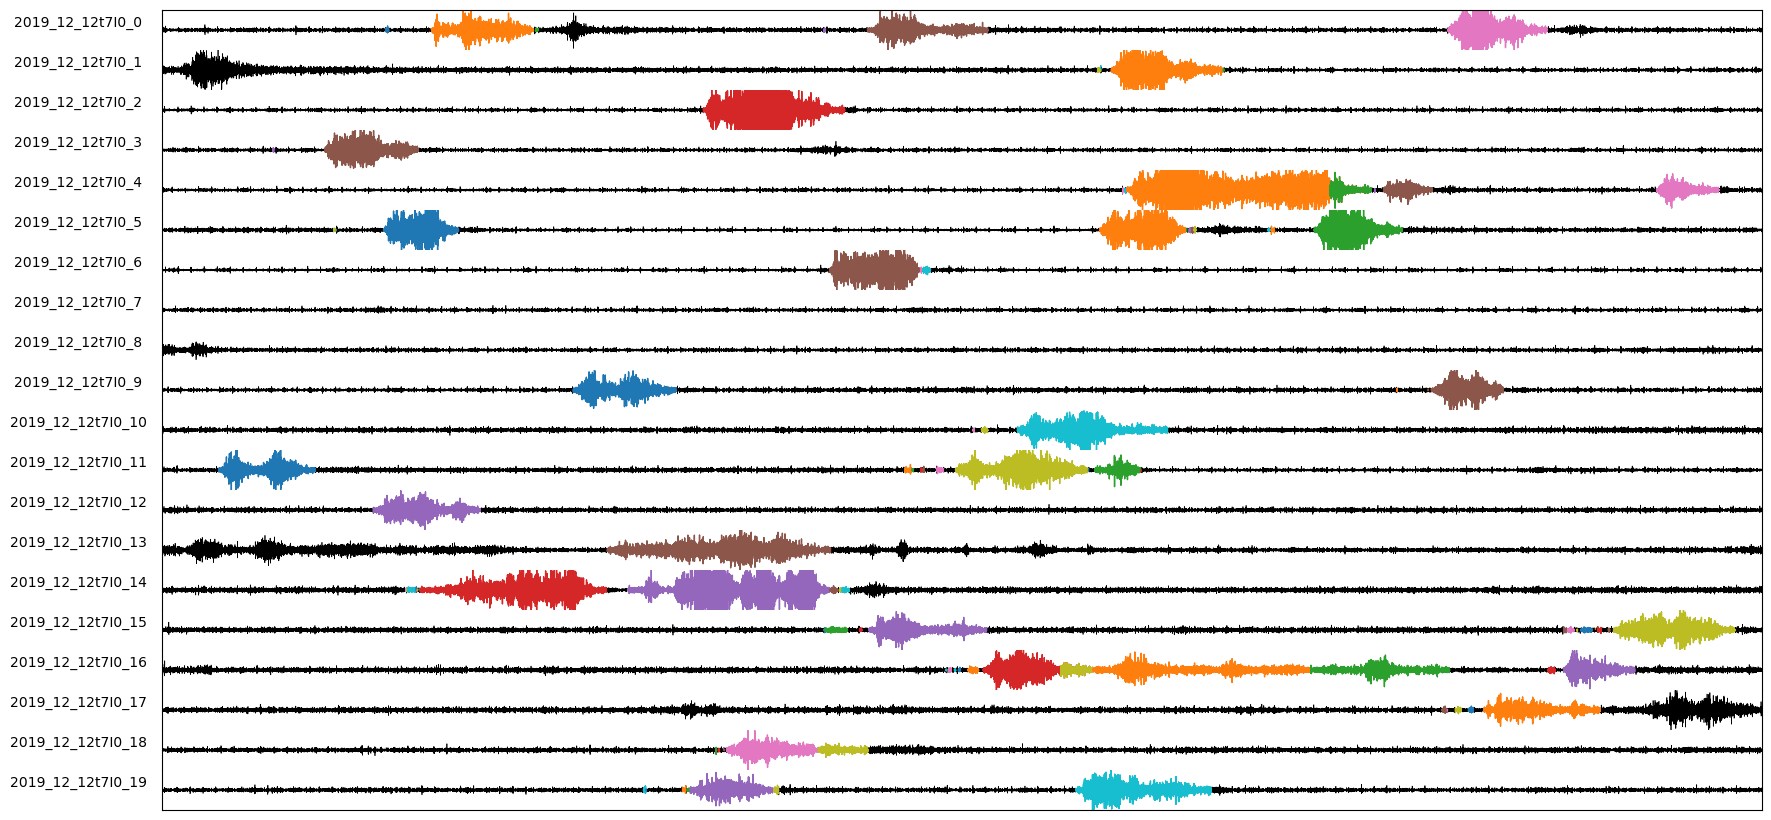

In [348]:
plot_all_channels(exact_time_events, data)

## Step 4: Clean the newly detected events.

4.1. Filter by amplitude.
4.2. Merge those which are very close.
4.3. Filter by minimum time.
4.4. Filter by calm period before / after the event.


Currently, a lot of debris is there -- short low amplitude events which should be filtered out.

In [349]:
exact_time_events['Amplitude'] = amplitude_all_events(exact_time_events, data)

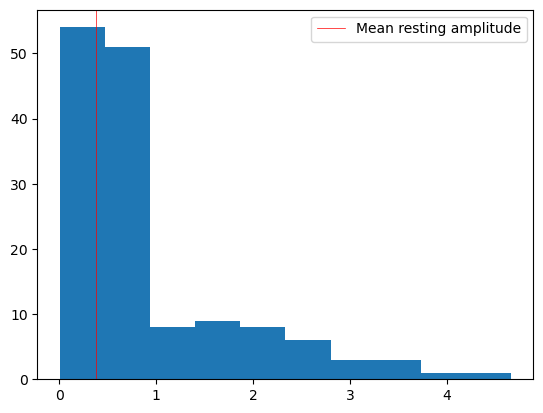

In [350]:
plt.hist(exact_time_events['Amplitude'])
plt.axvline(x = rest_amplitude, color = 'red', linewidth = 0.5, label = 'Mean resting amplitude')
plt.legend()
plt.show()

In [351]:
print(f'Number of events before filtering: {len(exact_time_events)}')
exact_time_events = exact_time_events[exact_time_events['Amplitude'] > amplitude_cutoff]
print(f'Number of events after filtering: {len(exact_time_events)}')

Number of events before filtering: 144
Number of events after filtering: 39


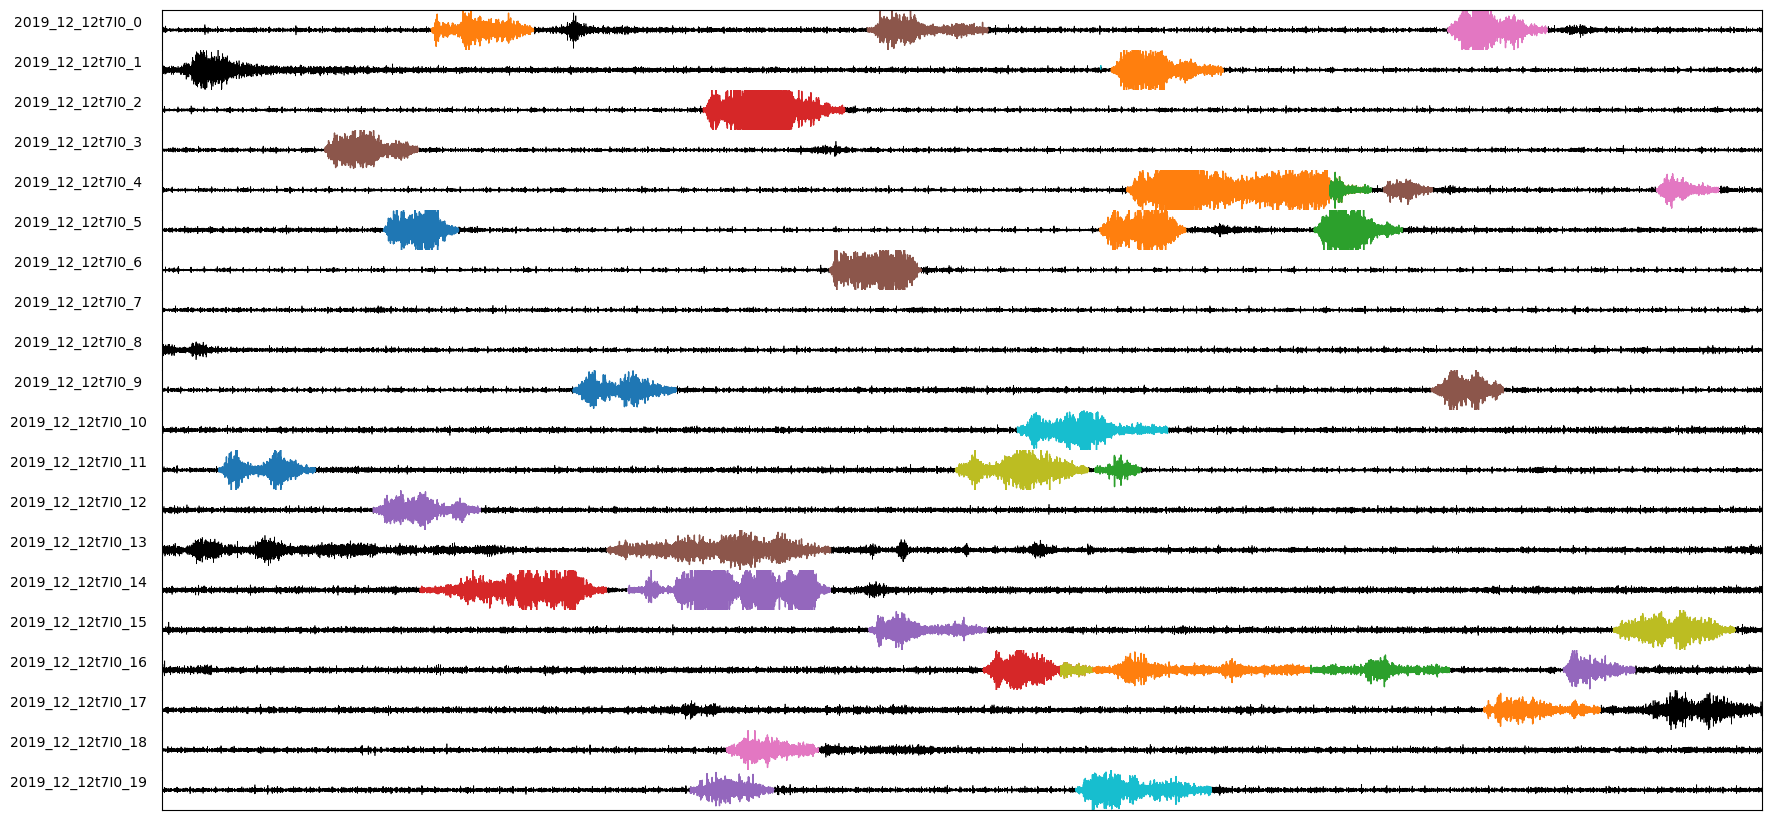

In [352]:
plot_all_channels(exact_time_events, data)

Looking better already! Now, merge events that are very close to each other.

In [353]:
max_merge_time = 0.1 # seconds
print(f'Will merge events that are less than {max_merge_time} seconds apart.')

Will merge events that are less than 0.1 seconds apart.


In [354]:
final_events = []

for channel in np.unique(exact_time_events['Channel']):
    dt = exact_time_events[exact_time_events['Channel'] == channel]
    dt = dt.sort_values(by = 'Start')
    dt = dt.reset_index(drop = True)
    
    i = 1
    while i < len(dt):
        previous_element = dt.iloc[i - 1]
        current_element = dt.iloc[i]
        
        if previous_element['Channel'] != current_element['Channel']:
            i = i + 1
            continue
        
        if previous_element['End'] + max_merge_time < current_element['Start']:
            i = i + 1
            continue
        
        dt.at[i, 'EventStart'] = previous_element['EventStart']
        dt.at[i, 'EventEnd'] = current_element['EventEnd']
    
        dt = dt.drop(i - 1)
        dt = dt.reset_index(drop = True)

    final_events.append(dt)

final_events = pd.concat(final_events)

In [355]:
final_events['EventLength'] = list(final_events['EventEnd'] - final_events['EventStart'])
final_events['Start'] = final_events['EventStart'] / data.info['sfreq']
final_events['End'] = final_events['EventEnd'] / data.info['sfreq']
final_events['Length'] = list(final_events['End'] - final_events['Start'])
final_events['Amplitude'] = amplitude_all_events(final_events, data)
final_events = final_events.reset_index(drop = True)

In [356]:
print(f'Number of events: {len(final_events)}')

Number of events: 29


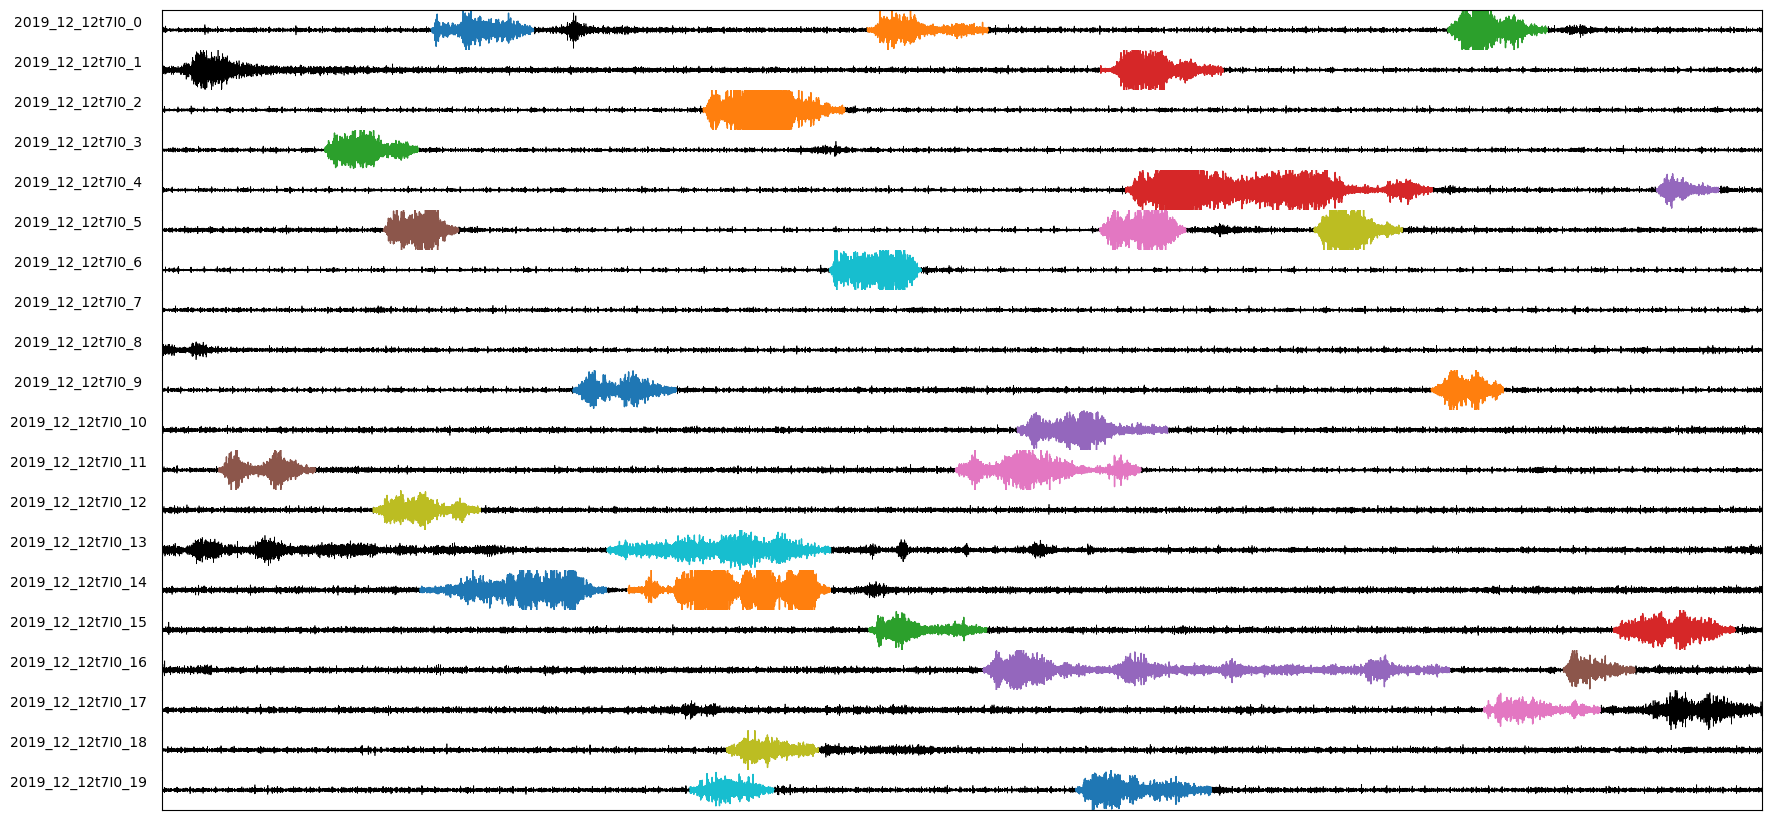

In [357]:
plot_all_channels(final_events, data)

In [358]:
final_events['AmplitudeBefore'] = around_amplitude_all_events(final_events, data, calm_time = 0.2, before_event = True)
final_events['AmplitudeAfter'] = around_amplitude_all_events(final_events, data, calm_time = 0.2, before_event = False)

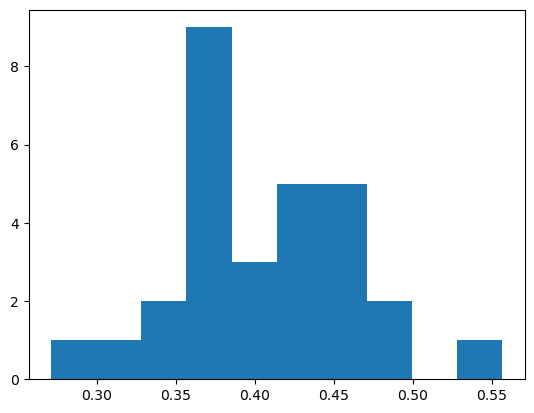

In [359]:
plt.hist(final_events['AmplitudeBefore'])
plt.show()

In [360]:
cutoff = np.mean(no_movement['Amplitude']) * 2
print(f'{cutoff}')

0.7655408972868248


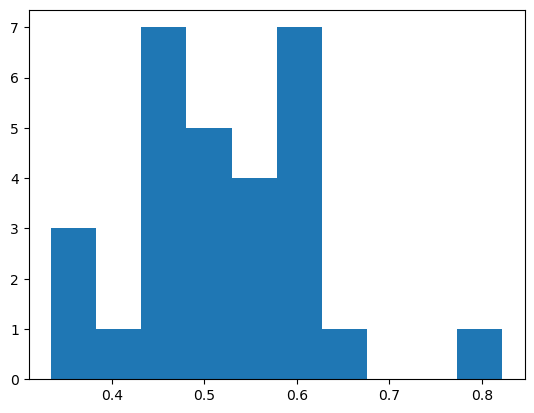

In [361]:
plt.hist(final_events['AmplitudeAfter'])
plt.show()

In [362]:
drop_events_start = final_events[ final_events['AmplitudeBefore'] > cutoff ]
drop_events_end = final_events[ final_events['AmplitudeAfter'] > cutoff ]
drop_events = pd.concat([drop_events_start, drop_events_end], ignore_index = True)
print(f'Events to be dropped: {len(drop_events)}')

Events to be dropped: 1


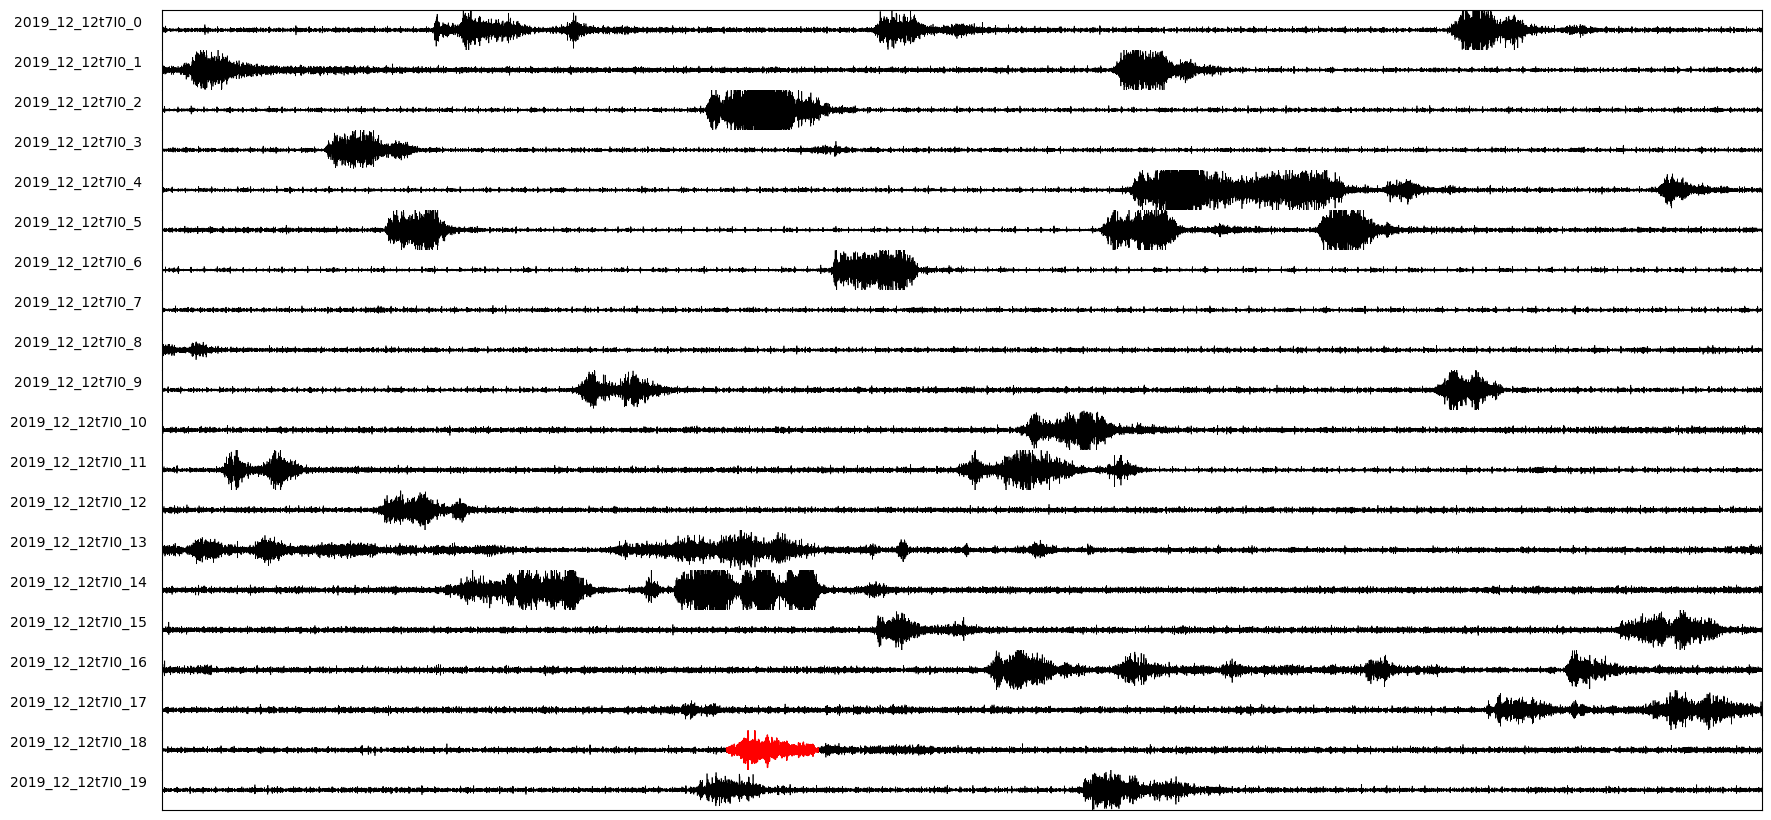

In [363]:
plot_all_channels(drop_events, data, color = ['red'])

In [364]:
cutoff = np.mean(no_movement['Amplitude']) * 2
final_events = final_events[ final_events['AmplitudeBefore'] < cutoff ]
final_events = final_events[ final_events['AmplitudeAfter'] < cutoff ]

print(f'Number of events after filtering: {len(final_events)}')

Number of events after filtering: 28


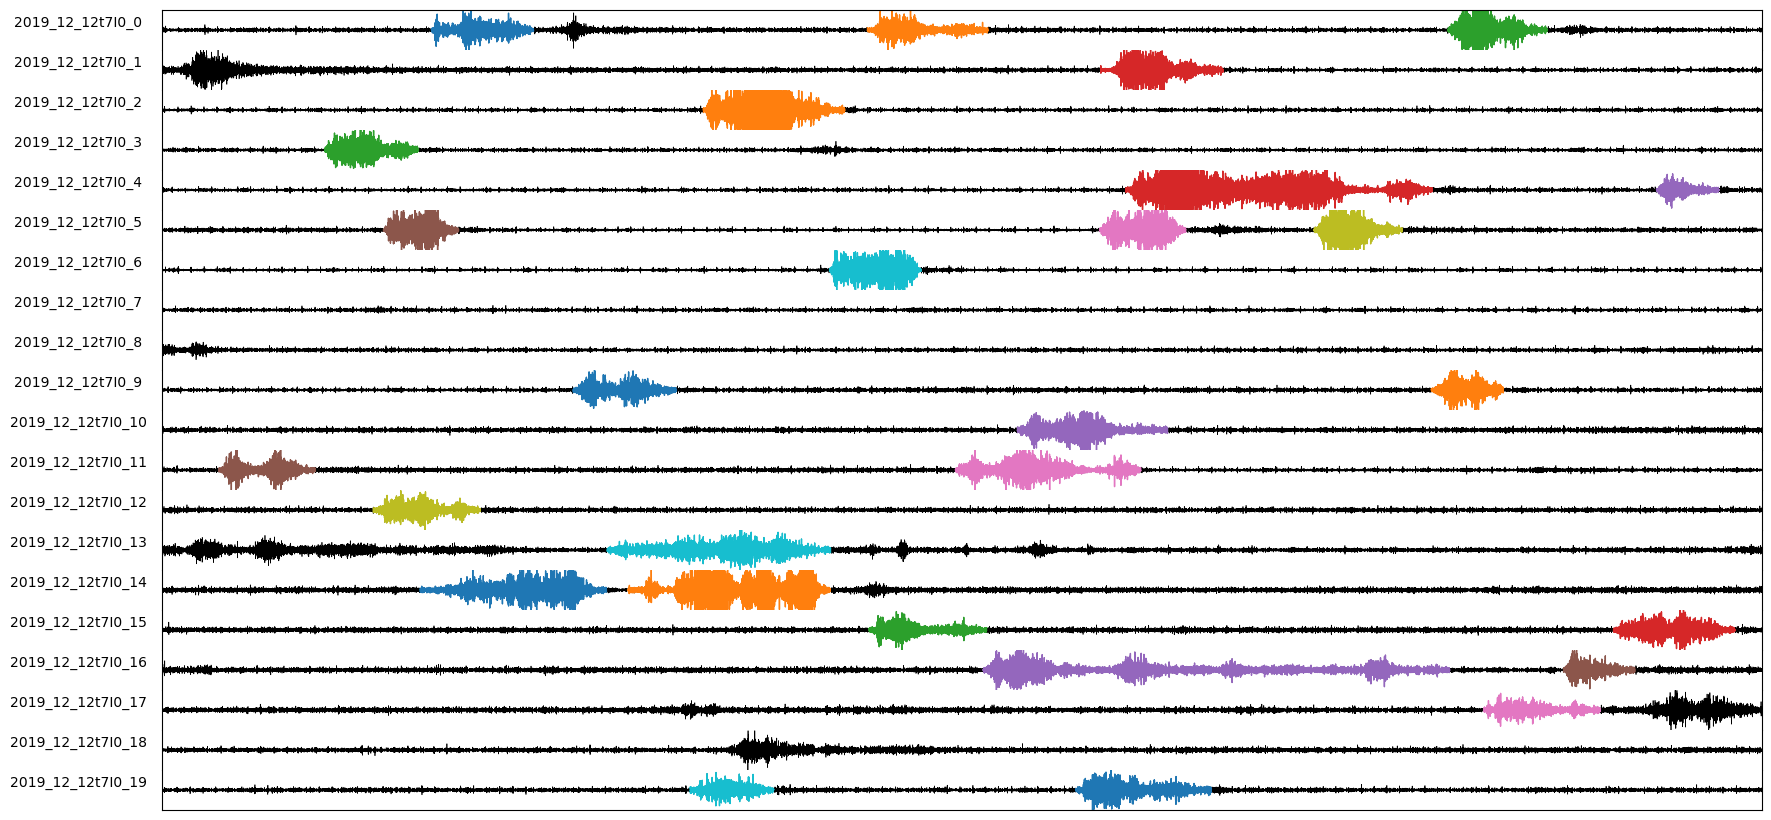

In [365]:
plot_all_channels(final_events, data)

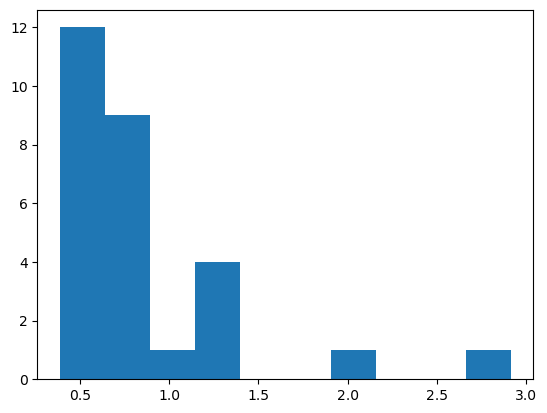

In [366]:
plt.hist(final_events['Length'])
plt.show()

In [367]:
final_events = final_events[ final_events['Length'] >= 0.25 ]
print(f'Number of events after filtering: {len(final_events)}')

Number of events after filtering: 28


# The final movement events

In [368]:
print(f'Number of events after filtering: {len(final_events)}')

Number of events after filtering: 28


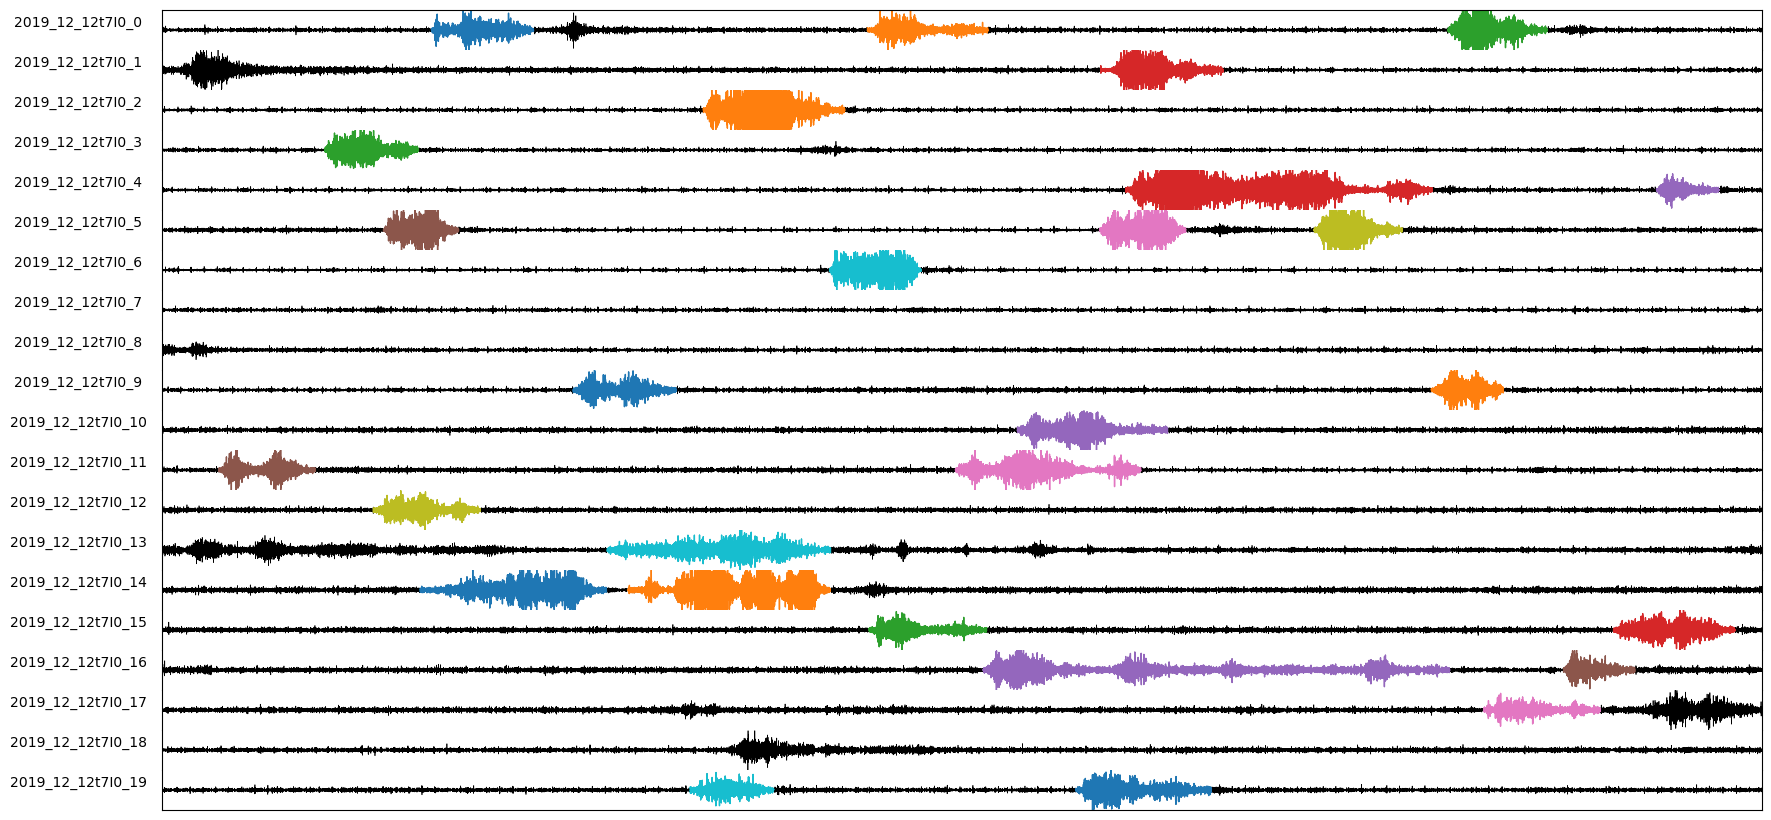

In [369]:
plot_all_channels(final_events, data)